[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giulatona/iecon2025_tutorial/blob/main/notebooks/03_forecasting_models.ipynb)

# Deep Learning for Energy Forecasting - Model Training

This notebook demonstrates training various forecasting models on the household power consumption dataset, from simple baselines to advanced deep learning architectures.

## Learning Objectives
- Implement baseline forecasting models (naive seasonal)
- Build and train feedforward neural networks for time series
- Develop LSTM Encoder-Decoder architectures
- Compare model performance and understand trade-offs
- Apply proper evaluation metrics for time series forecasting

## 1. Setup and Data Loading

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#import warnings
#warnings.filterwarnings('ignore')

# Deep learning frameworks
import tensorflow as tf
import keras

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

GPU available: []


In [2]:
# Avoid loading ipywidgets assets from the public CDN (helps prevent widget-related kernel crashes)
import os
os.environ["JUPYTER_WIDGETS_CDN"] = "none"


### Data Download if needed

We'll use the same household power consumption dataset from the UCI Machine Learning Repository.

In [3]:
# Download data if not available locally
import os
import urllib.request
import zipfile

# Check if running in Google Colab
in_colab = 'google.colab' in str(get_ipython())

if in_colab:
    print("Running in Google Colab - downloading dataset...")
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip -q household_power_consumption.zip
    data_file = 'household_power_consumption.txt'
else:
    print("Running locally...")
    data_file = 'data/household_power_consumption.txt'
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    
    # Download dataset if it doesn't exist locally
    if not os.path.exists(data_file):
        print("Dataset not found locally. Downloading...")
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
        zip_file = 'data/household_power_consumption.zip'
        
        # Download the zip file
        urllib.request.urlretrieve(url, zip_file)
        print("Download completed. Extracting...")
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('data/')
        
        print("Extraction completed.")
    else:
        print("Dataset found locally.")

print(f"Using data file: {data_file}")

Running locally...
Dataset found locally.
Using data file: data/household_power_consumption.txt


## 2. Import Preprocessing Functions

We need the preprocessing functions from notebook 02. Here are the options for including them:

In [4]:
# Import preprocessing functions from shared utilities module

# Add the src directory to Python path for imports
if in_colab:
    # For Colab, install the package directly from GitHub
    print("Installing iecon2025_tutorial package from GitHub...")
    try:
        %pip install git+https://github.com/giulatona/iecon2025_tutorial.git
        from iecon2025_tutorial.preprocessing import load_and_preprocess_data
        print("✅ Successfully installed and imported preprocessing functions from GitHub")
    except Exception as e:
        print(f"❌ Installation error: {e}")
        print("Please check the GitHub repository URL and try again")
else:
    try:
        from iecon2025_tutorial.preprocessing import load_and_preprocess_data
        print("✅ Successfully imported preprocessing functions from local utilities module")
    except ImportError as e:
        print(f"❌ Import error: {e}")
        print("Please ensure the src/iecon2025_tutorial directory contains preprocessing.py")

✅ Successfully imported preprocessing functions from local utilities module


## 3. Data Loading and Basic Preprocessing

In [5]:
# Setup configuration for preprocessing and training
SETUP_CONFIG = {
    'window_size': 36,          # 36 hours of historical data
    'forecast_horizon': 24,     # Predict next 24 hours
    'batch_size': 32,
    'max_epochs': 50,
    'validation_split': 0.2,
    'initial_learning_rate': 0.01,
    'target_columns': [0],      # Index of target variable (Global_active_power)
    'use_time_features': True,
    'use_holiday_features': False,
    'downsample_freq': '1H',
    'num_fourier_terms': 3,
}

In [6]:
# Load and preprocess the dataset using the preprocessing pipeline
results = load_and_preprocess_data(
    data_path=str(data_file),
    downsample_freq=SETUP_CONFIG['downsample_freq'],
    num_fourier_terms=SETUP_CONFIG['num_fourier_terms'],
    window_size=SETUP_CONFIG['window_size'],
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    batch_size=SETUP_CONFIG['batch_size'],
    target_columns=SETUP_CONFIG['target_columns'],  # Predict Global_active_power only
    use_time_features=SETUP_CONFIG['use_time_features'],
    use_holiday_features=SETUP_CONFIG['use_holiday_features'],
    verbose=True  # Enable function's verbose output
)

# Extract the datasets and metadata
train_dataset = results['datasets']['train']
val_dataset = results['datasets']['val']
test_dataset = results['datasets']['test']

scaler_params = results['scaler_params']
feature_names = results['feature_names']
preprocessing_info = results['preprocessing_info']

raw_train_df = results['raw_data']['train']
raw_val_df = results['raw_data']['val']
raw_test_df = results['raw_data']['test']

# Get data shapes for model building
for inputs, targets in train_dataset.take(1):
    input_shape = inputs.shape
    target_shape = targets.shape
    num_features = input_shape[-1]
    break

# Show final summary
print(f"Ready for training - Input: {input_shape}, Target: {target_shape}")
print(f"Features: {preprocessing_info['feature_count']}, Samples: {preprocessing_info['split_info']['train_samples']:,}")

Starting preprocessing pipeline...
✅ Data loaded and cleaned
✅ Missing values filled
✅ Time features added


/workspaces/iecon2025_tutorial/src/iecon2025_tutorial/preprocessing.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_downsampled = df.resample(freq).mean()


✅ Data downsampled
✅ Data split completed
✅ Features normalized
✅ Sliding windows created
✅ Preprocessing pipeline completed!
Ready for training - Input: (32, 36, 19), Target: (32, 24, 1)
Features: 19, Samples: 24,212


In [7]:
print("Feature names:")
for name in feature_names:
    print(f"  - {name}")

Feature names:
  - Global_active_power
  - Global_reactive_power
  - Voltage
  - Global_intensity
  - Sub_metering_1
  - Sub_metering_2
  - Sub_metering_3
  - Day sin1
  - Day cos1
  - Year sin1
  - Year cos1
  - Day sin2
  - Day cos2
  - Year sin2
  - Year cos2
  - Day sin3
  - Day cos3
  - Year sin3
  - Year cos3


## 4. Baseline Models

The naive seasonal baseline assumes the target series repeats after a fixed seasonal lag (e.g., the previous day or week). Given an input window of length `W`, a forecast horizon `H`, and a seasonal period `S`, the prediction simply copies the target feature from `S` steps earlier: $\hat{y}_{t+h} = y_{t+h-S}$ for $h = 1,...,H$. This strong yet parameter-free benchmark highlights how much value more complex models add.

To implement this baseline with the Keras **Functional API**, we will:
- declare an `Input` layer that exposes the `(window_size, num_features)` tensor coming from the data pipeline,
- slice the incoming tensor with a `Lambda` layer to copy the seasonal portion of the target feature, and
- wrap the result in a `keras.Model` so it integrates seamlessly with Keras training, evaluation, and metric utilities.

In [8]:
SEASONAL_PERIOD = 24  # Number of time steps representing one seasonal cycle
used_target_index = SETUP_CONFIG['target_columns'][0]

def build_naive_seasonal_model(window_size, forecast_horizon, num_features, seasonal_period, target_index=0):
    """Return a keras.Model that copies the target from the previous seasonal cycle."""
    if window_size < seasonal_period:
        raise ValueError("window_size must be >= seasonal_period for the naive seasonal baseline.")
    if forecast_horizon > seasonal_period:
        raise ValueError("forecast_horizon must be <= seasonal_period for the naive seasonal baseline.")

    start_idx = window_size - seasonal_period
    end_idx = start_idx + forecast_horizon

    inputs = keras.layers.Input(shape=(window_size, num_features), name="inputs")

    def seasonal_copy(x):
        return x[:, start_idx:end_idx, target_index:target_index + 1]

    outputs = keras.layers.Lambda(seasonal_copy, name="naive_seasonal_copy")(inputs)
    return keras.Model(inputs=inputs, outputs=outputs, name="naive_seasonal_model")

naive_seasonal_model = build_naive_seasonal_model(
    window_size=SETUP_CONFIG['window_size'],
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    num_features=num_features,
    seasonal_period=SEASONAL_PERIOD,
    target_index=used_target_index,
)

Let's see how to make a prediction with the model

In [9]:
# we make a batch with a single example
# the example has zeros everywhere except for the last seasonal_period time steps of the target feature
# which are filled with a simple increasing sequence 1, 2, ..., seasonal_period
# we expect the model to copy the last seasonal_period values into the forecast horizon
example_input = np.zeros((1, SETUP_CONFIG['window_size'], num_features), dtype=np.float32)
example_input[:, -SEASONAL_PERIOD:, used_target_index] = np.arange(1, SEASONAL_PERIOD + 1, dtype=np.float32)


# to run the model we call it (like a function) on the example input
example_output = naive_seasonal_model(example_input)


print("Example output shape:", example_output.shape)


print("Input target feature values:", example_input[0, :, used_target_index])
print("Output target feature values:", example_output.numpy()[0, :, 0])

Example output shape: (1, 24, 1)
Input target feature values: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.
  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]
Output target feature values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]


In [10]:
naive_seasonal_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [11]:
def plot_forecast_sample(model, dataset, config, sample_index=0, target_index=0, title=None):
    """Plot history, ground truth, and model forecast for one sample from the first batch."""
    inputs, targets = next(iter(dataset))
    inputs_np = inputs.numpy()
    targets_np = targets.numpy()
    preds_np = model.predict(inputs, verbose=0)

    batch_size = inputs_np.shape[0]
    if sample_index >= batch_size:
        raise ValueError(f"sample_index {sample_index} out of range for batch size {batch_size}.")

    window_size = config['window_size']
    forecast_horizon = config['forecast_horizon']

    history_steps = range(window_size)
    forecast_steps = range(window_size, window_size + forecast_horizon)

    plt.figure(figsize=(10, 4))
    plt.plot(history_steps, inputs_np[sample_index, :, target_index], label="History")
    plt.plot(forecast_steps, targets_np[sample_index, :, target_index], label="Ground Truth", marker="o")
    plt.plot(forecast_steps, preds_np[sample_index, :, target_index], label="Forecast", marker="o")
    plt.xlabel("Time step")
    plt.ylabel("Global_active_power (scaled)")
    if title is None:
        title = f"Forecast comparison (sample {sample_index})"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

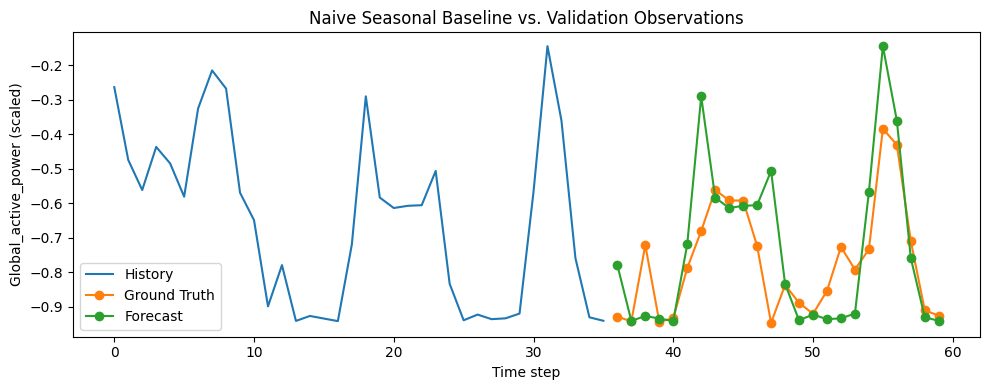

In [12]:
plot_forecast_sample(
    model=naive_seasonal_model,
    dataset=val_dataset,
    config=SETUP_CONFIG,
    sample_index=0,
    target_index=used_target_index,
    title="Naive Seasonal Baseline vs. Validation Observations"
)

### Evaluate on Each Dataset Split

`model.evaluate` runs a forward pass and computes the configured loss/metrics. We loop through the train/validation/test datasets produced by the preprocessing step to understand how the baseline performs across all splits.

In [13]:
split_datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
}
baseline_metrics = {}
for split_name, dataset in split_datasets.items():
    baseline_metrics[split_name] = naive_seasonal_model.evaluate(dataset, verbose=0, return_dict=True)

In [14]:
for split_name, values in baseline_metrics.items():
    print(f"{split_name} metrics:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")

train metrics:
  loss: 0.0941
  mae: 0.2055
  rmse: 0.3067
val metrics:
  loss: 0.0864
  mae: 0.2039
  rmse: 0.2940
test metrics:
  loss: 0.0533
  mae: 0.1549
  rmse: 0.2309


## 5. Feedforward Neural Network Baseline

We now transition from parameter-free baselines to a small fully connected network. The idea is to flatten the input window, pass it through a configurable stack of dense layers, and produce the multi-step forecast. By controlling the number of layers and units with a simple list, we can quickly experiment with wider or deeper architectures.

In [15]:
DENSE_LAYER_UNITS = [128, 64]

def build_feedforward_forecaster(window_size, num_features, forecast_horizon, dense_units, target_dim=1):
    """Create a feedforward network for multi-step forecasting."""
    inputs = keras.layers.Input(shape=(window_size, num_features), name="ffnn_inputs")
    #x = keras.layers.Flatten(name="flatten_window")(inputs)
    x = keras.layers.Reshape(name="reshape_flat", target_shape=(window_size * num_features,))(inputs)
    for i, units in enumerate(dense_units):
        x = keras.layers.Dense(units, activation="relu", name=f"dense_{i+1}")(x)
    x = keras.layers.Dense(forecast_horizon * target_dim, name="forecast_head")(x)
    outputs = keras.layers.Reshape(target_shape=(forecast_horizon, target_dim), name="reshape_output")(x)
    return keras.Model(inputs=inputs, outputs=outputs, name="feedforward_forecaster")

feedforward_model = build_feedforward_forecaster(
    window_size=SETUP_CONFIG['window_size'],
    num_features=num_features,
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    dense_units=DENSE_LAYER_UNITS
)

feedforward_model.summary()

Model: "feedforward_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ffnn_inputs (InputLayer)        │ (None, 36, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_flat (Reshape)          │ (None, 684)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        87,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_head (Dense)           │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_output (Reshape)        │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,496 (380.84 KB)

 Trainable params: 97,496 (380.84 KB)

 Non-trainable params: 0 (0.00 B)

None in the output shape refers to the batch size. It just means that it is unspecified, so the model can be called with different batch sizes

In [16]:
feedforward_model(example_input)

<tf.Tensor: shape=(1, 24, 1), dtype=float32, numpy=
array([[[-0.8277869 ],
        [-0.5160704 ],
        [ 0.5715101 ],
        [-2.8522565 ],
        [ 0.0920256 ],
        [-2.3684638 ],
        [-0.31269872],
        [ 3.6971543 ],
        [ 0.5614229 ],
        [-2.1170552 ],
        [-2.3603246 ],
        [ 0.45773005],
        [ 1.230105  ],
        [-1.7505    ],
        [ 4.047383  ],
        [ 1.175788  ],
        [ 0.9634675 ],
        [-1.6959065 ],
        [-0.3106826 ],
        [ 1.1874472 ],
        [ 3.8569248 ],
        [ 1.9842871 ],
        [-2.4517639 ],
        [-2.95802   ]]], dtype=float32)>

In [17]:
feedforward_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=SETUP_CONFIG['initial_learning_rate']),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

As reference for later, lets evaluate the untrained model (with weights initialized at random) and look at the metrics

In [18]:
untrained_ff_metrics = {}
for split_name, dataset in split_datasets.items():
    untrained_ff_metrics[split_name] = feedforward_model.evaluate(dataset, verbose=0, return_dict=True)

for split_name, values in untrained_ff_metrics.items():
    print(f"{split_name} metrics:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")

train metrics:
  loss: 0.8637
  mae: 0.7915
  rmse: 0.9294
val metrics:
  loss: 0.7909
  mae: 0.7451
  rmse: 0.8893
test metrics:
  loss: 0.8719
  mae: 0.8056
  rmse: 0.9337


In [19]:
history = feedforward_model.fit(train_dataset, validation_data=val_dataset, epochs=SETUP_CONFIG['max_epochs'], verbose=1)

Epoch 1/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2002 - mae: 0.3373 - rmse: 0.4343 - val_loss: 0.0741 - val_mae: 0.2145 - val_rmse: 0.2723
Epoch 2/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0746 - mae: 0.2086 - rmse: 0.2731 - val_loss: 0.0656 - val_mae: 0.2006 - val_rmse: 0.2562
Epoch 3/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0682 - mae: 0.1980 - rmse: 0.2612 - val_loss: 0.0614 - val_mae: 0.1930 - val_rmse: 0.2478
Epoch 4/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0648 - mae: 0.1921 - rmse: 0.2545 - val_loss: 0.0587 - val_mae: 0.1876 - val_rmse: 0.2423
Epoch 5/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0626 - mae: 0.1881 - rmse: 0.2502 - val_loss: 0.0568 - val_mae: 0.1840 - val_rmse: 0.2384
Epoch 6/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0610 - mae: 0.1851 - rmse: 0.2470 - val_loss: 0.0554 - val_mae: 0.1809 - val_rmse: 0.2354
Epoch 7/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0598 - mae: 0.1828 - rmse:

### Training Curves

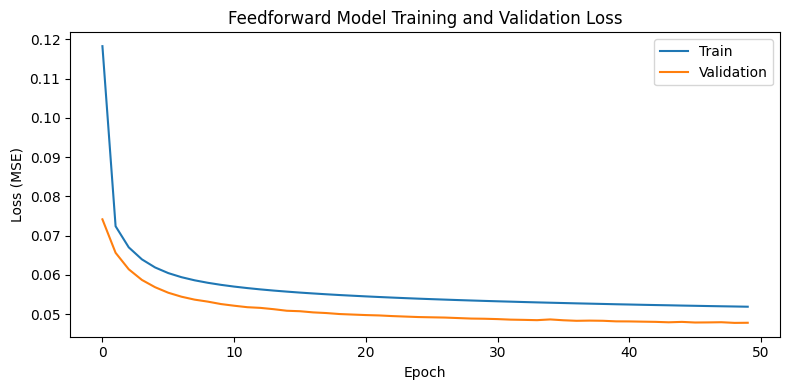

In [20]:
if history is None:
    raise ValueError("Run the training cell to populate `history` before plotting.")

history_df = pd.DataFrame(history.history)
ax = history_df[["loss", "val_loss"]].plot(figsize=(8, 4))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Feedforward Model Training and Validation Loss")
ax.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

In [21]:
ff_metrics = {}
for split_name, dataset in split_datasets.items():
    ff_metrics[split_name] = feedforward_model.evaluate(dataset, verbose=0, return_dict=True)

for split_name, values in ff_metrics.items():
    print(f"{split_name} metrics:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")


train metrics:
  loss: 0.0518
  mae: 0.1665
  rmse: 0.2275
val metrics:
  loss: 0.0478
  mae: 0.1637
  rmse: 0.2186
test metrics:
  loss: 0.0336
  mae: 0.1357
  rmse: 0.1834


### Feedforward Forecast Sample

Visualizing a single forecast helps build intuition about how the network extrapolates the recent trend, but it is easy to over-interpret any one curve. Treat these plots as qualitative spot checks and rely on the validation metrics for objective model comparisons.

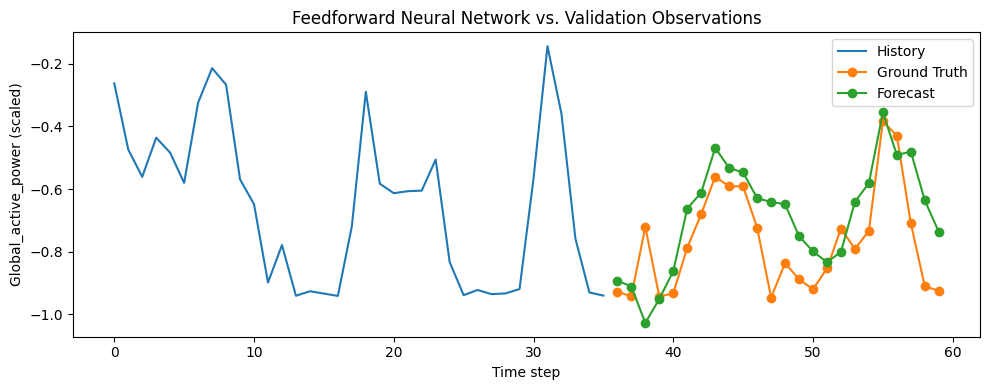

In [22]:
plot_forecast_sample(
    model=feedforward_model,
    dataset=val_dataset,
    config=SETUP_CONFIG,
    sample_index=0,
    target_index=used_target_index,
    title="Feedforward Neural Network vs. Validation Observations"
)

### Compare Validation Metrics

In [23]:
import pandas as pd

def format_metric_dict(metric_dict):
    return {name: float(value) for name, value in metric_dict.items()}

comparison_df = pd.DataFrame(
    {
        "Naive Seasonal": format_metric_dict(baseline_metrics.get("val", {})),
        "Untrained FF NN": format_metric_dict(untrained_ff_metrics.get("val", {})),
        "Feedforward NN": format_metric_dict(ff_metrics.get("val", {})),
    }
).T

comparison_df

,loss,mae,rmse
Naive Seasonal,0.086434,0.203913,0.293996
Untrained FF NN,0.790852,0.745079,0.889298
Feedforward NN,0.047777,0.163691,0.218578


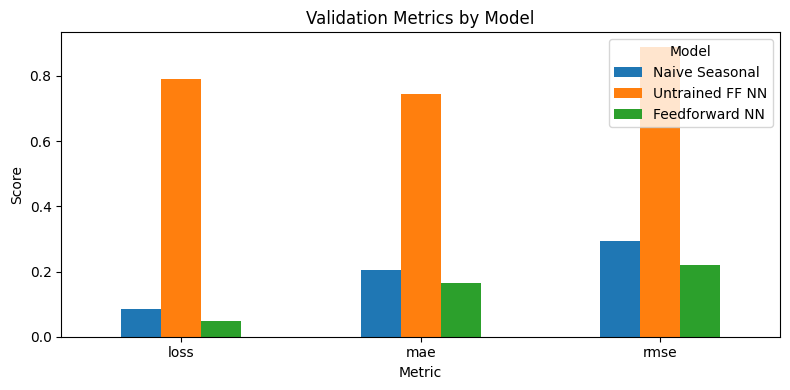

In [24]:
comparison_by_metric = comparison_df.T
ax = comparison_by_metric.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_title("Validation Metrics by Model")
ax.set_xticklabels(comparison_by_metric.index, rotation=0)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

## 6. LSTM Encoder-Decoder

Recurrent encoder-decoder models process the input window step by step, compressing it into a latent state that summarizes the recent dynamics. The decoder then unfolds that state across the forecast horizon to predict future values. This architecture handles variable-length sequences gracefully and is a natural baseline before trying attention-based transformers.

In [25]:
class EncoderDecoderLSTM(keras.Model):
    """Simple encoder-decoder LSTM for multi-step forecasting."""
    def __init__(self, latent_dim, forecast_horizon, target_dim, dropout_rate=0.0):
        super().__init__()
        self.encoder = keras.layers.LSTM(
            latent_dim,
            return_state=True,
            name="encoder_lstm"
        )
        self.dropout = keras.layers.Dropout(dropout_rate, name="encoder_dropout") if dropout_rate > 0 else None
        # we repeat the context vector for each time step in the forecast horizon
        self.repeat = keras.layers.RepeatVector(forecast_horizon, name="repeat_context")
        self.decoder = keras.layers.LSTM(
            latent_dim,
            return_sequences=True,
            name="decoder_lstm"
        )
        self.projection = keras.layers.Dense(target_dim, name="forecast_dense") # it is automatically applied to each time step

    def call(self, inputs, training=False):
        encoder_output, state_h, state_c = self.encoder(inputs)
        if self.dropout is not None and training:
            encoder_output = self.dropout(encoder_output, training=training)
        repeated = self.repeat(encoder_output)

        # the decoder receives at each time step the result of the encoding repeated
        # and as initial state the final state of the encoder
        decoder_output = self.decoder(repeated, initial_state=[state_h, state_c])
        return self.projection(decoder_output)

In [26]:
LATENT_DIM = 128
TARGET_DIM = len(SETUP_CONFIG['target_columns'])
lstm_model = EncoderDecoderLSTM(
    latent_dim=LATENT_DIM,
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    target_dim=TARGET_DIM,
    dropout_rate=0.1
)

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

lstm_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )
]

lstm_history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,  # TRAINING_CONFIG['epochs'],
    callbacks=lstm_callbacks,
    verbose=1
)

lstm_model.summary()

Epoch 1/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - loss: 0.0760 - mae: 0.2096 - rmse: 0.2733 - val_loss: 0.0469 - val_mae: 0.1592 - val_rmse: 0.2165
Epoch 2/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - loss: 0.0521 - mae: 0.1658 - rmse: 0.2282 - val_loss: 0.0468 - val_mae: 0.1640 - val_rmse: 0.2164


Model: "encoder_decoder_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ ((None, 128), (None,   │        75,776 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_context (RepeatVector)   │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_dense (Dense)          │ (None, 24, 1)          │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,469 (2.37 MB)

 Trainable params: 207,489 (810.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 414,980 (1.58 MB)

In [27]:
lstm_metrics = {}
for split_name, dataset in split_datasets.items():
    lstm_metrics[split_name] = lstm_model.evaluate(dataset, verbose=0, return_dict=True)

### LSTM Training Curves

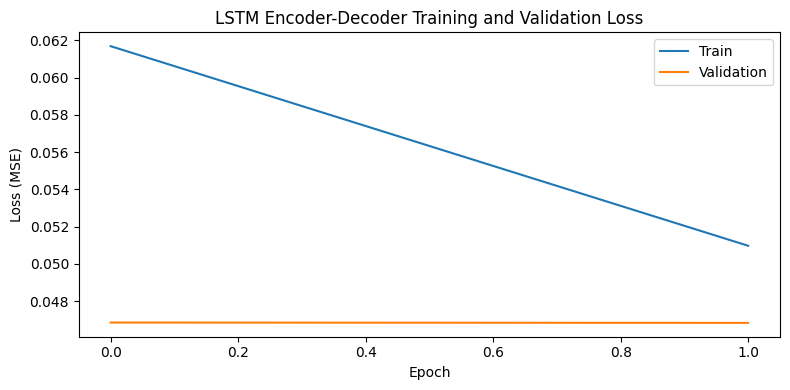

In [28]:
if lstm_history is None:
    raise ValueError("Run the LSTM training cell before plotting the learning curves.")

lstm_history_df = pd.DataFrame(lstm_history.history)
ax = lstm_history_df[["loss", "val_loss"]].plot(figsize=(8, 4))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.set_title("LSTM Encoder-Decoder Training and Validation Loss")
ax.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

### Forecast Sample on the Validation Set

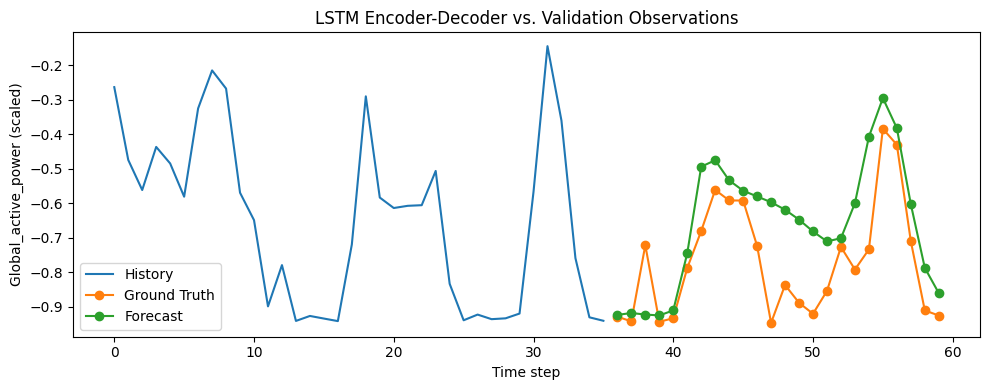

In [29]:
plot_forecast_sample(
    model=lstm_model,
    dataset=val_dataset,
    config=SETUP_CONFIG,
    sample_index=0,
    target_index=used_target_index,
    title="LSTM Encoder-Decoder vs. Validation Observations"
)

### Alternate LSTM Encoder-Decoder Configuration

In [30]:
LATENT_DIM_ALT = 64
DROPOUT_ALT = 0.3
ALT_LEARNING_RATE = 5e-4

lstm_model_compact = EncoderDecoderLSTM(
    latent_dim=LATENT_DIM_ALT,
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    target_dim=TARGET_DIM,
    dropout_rate=DROPOUT_ALT,
)

lstm_model_compact.compile(
    optimizer=keras.optimizers.Adam(learning_rate=ALT_LEARNING_RATE),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

lstm_callbacks_alt = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

lstm_history_compact = lstm_model_compact.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,  # Adjust upward when you have more time to train
    callbacks=lstm_callbacks_alt,
    verbose=1,
)

lstm_model_compact.summary()

Epoch 1/2


755/755 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - loss: 0.1016 - mae: 0.2434 - rmse: 0.3121 - val_loss: 0.0611 - val_mae: 0.1989 - val_rmse: 0.2473
Epoch 2/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.0631 - mae: 0.1910 - rmse: 0.2512 - val_loss: 0.0482 - val_mae: 0.1674 - val_rmse: 0.2195


Model: "encoder_decoder_lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ ((None, 64), (None,    │        21,504 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_context (RepeatVector)   │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_dense (Dense)          │ (None, 24, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,781 (639.77 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 109,188 (426.52 KB)

In [31]:
lstm_compact_metrics = {}
for split_name, dataset in split_datasets.items():
    lstm_compact_metrics[split_name] = lstm_model_compact.evaluate(dataset, verbose=0, return_dict=True)

for split_name, values in lstm_compact_metrics.items():
    print(f"{split_name} metrics (compact LSTM):")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")

train metrics (compact LSTM):
  loss: 0.0530
  mae: 0.1690
  rmse: 0.2302
val metrics (compact LSTM):
  loss: 0.0482
  mae: 0.1674
  rmse: 0.2195
test metrics (compact LSTM):
  loss: 0.0343
  mae: 0.1371
  rmse: 0.1852


### Compare Validation Metrics Including the LSTM

In [32]:
lstm_val_comparison_df = pd.DataFrame(
    {
        "Naive Seasonal": format_metric_dict(baseline_metrics.get("val", {})),
        "Feedforward NN": format_metric_dict(ff_metrics.get("val", {})),
        "LSTM Encoder-Decoder (128 units)": format_metric_dict(lstm_metrics.get("val", {})),
        "LSTM Encoder-Decoder (64 units)": format_metric_dict(lstm_compact_metrics.get("val", {})),
    }
).T

lstm_val_comparison_df

,loss,mae,rmse
Naive Seasonal,0.086434,0.203913,0.293996
Feedforward NN,0.047777,0.163691,0.218578
LSTM Encoder-Decoder (128 units),0.046837,0.164013,0.216419
LSTM Encoder-Decoder (64 units),0.048163,0.167386,0.219462


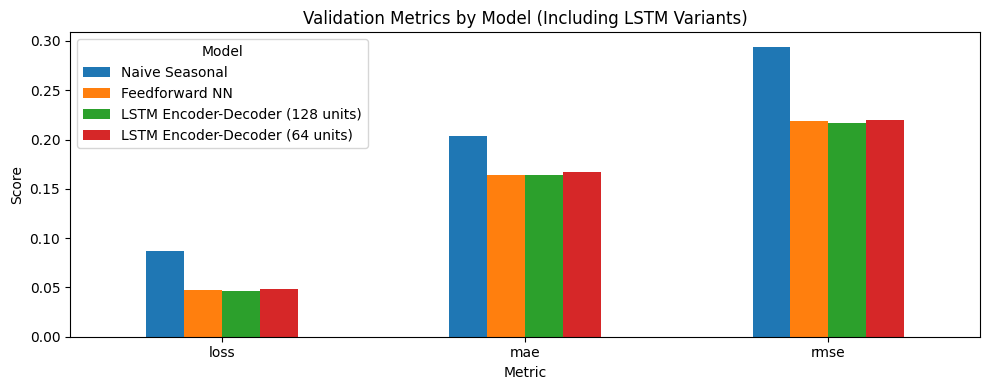

In [33]:
lstm_val_comparison_by_metric = lstm_val_comparison_df.T
ax = lstm_val_comparison_by_metric.plot(kind="bar", figsize=(10, 4))
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_title("Validation Metrics by Model (Including LSTM Variants)")
ax.set_xticklabels(lstm_val_comparison_by_metric.index, rotation=0)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

💡 **Try It Yourself:** Experiment by tweaking the latent dimension, dropout, learning rate, or number of epochs in either LSTM block above. Re-run the training and comparison cells to see how the validation metrics shift and discuss what configurations work best.

### Compare Test Metrics

With hyperparameters selected on the validation set, we can now benchmark the best-performing models on the held-out test split to estimate their real-world generalization.

In [34]:
test_comparison_df = pd.DataFrame(
    {
        "Naive Seasonal": format_metric_dict(baseline_metrics.get("test", {})),
        "Feedforward NN": format_metric_dict(ff_metrics.get("test", {})),
        "LSTM Encoder-Decoder (128 units)": format_metric_dict(lstm_metrics.get("test", {})),
    }
).T

test_comparison_df

,loss,mae,rmse
Naive Seasonal,0.053326,0.154933,0.230923
Feedforward NN,0.033618,0.135653,0.183351
LSTM Encoder-Decoder (128 units),0.032191,0.132999,0.179418


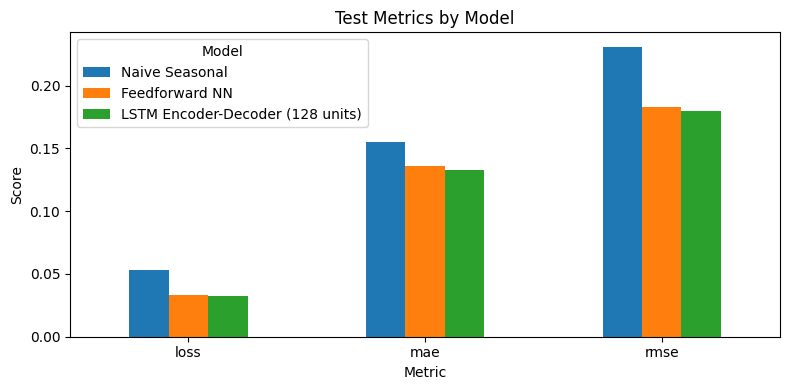

In [35]:
test_comparison_by_metric = test_comparison_df.T
ax = test_comparison_by_metric.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_title("Test Metrics by Model")
ax.set_xticklabels(test_comparison_by_metric.index, rotation=0)
ax.legend(title="Model")
plt.tight_layout()
plt.show()